<a href="https://colab.research.google.com/github/Mik-27/NLP-Coursework/blob/main/NLP%20Project/whatsappChatAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# WhatsApp Chat Analysis

In [1]:
!pip install emoji


     |████████████████████████████████| 175 kB 4.8 MB/s 
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171046 sha256=816f2eabf1bab18a27f8626b1b057028eaa11d3cb01b007479bc0d9b39873243
  Stored in directory: /root/.cache/pip/wheels/8a/4e/b6/57b01db010d17ef6ea9b40300af725ef3e210cb1acfb7ac8b6
Successfully built emoji


In [2]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import *
import datetime as dt
from matplotlib.ticker import MaxNLocator
import regex
import emoji
from seaborn import *
#from heatmap import heatmap
from wordcloud import WordCloud , STOPWORDS , ImageColorGenerator
from nltk import *
from plotly import express as px

In [3]:
### Python code to extract Date from chat file 

def startsWithDateAndTime(s):
  pattern = '^([0-9]+)(\/)([0-9]+)(\/)([0-9]+), ([0-9]+):([0-9]+)[ ]?(AM|PM|am|pm)? -'
  result = re.match(pattern, s)
  if result:
    return True
  return False

In [4]:
def FindAuthor(s):
  s=s.split(":")
  if len(s)==2:
    return True
  else:
    return False

In [5]:
### Extracting Date, Time, Author and message from the chat file.
def getDataPoint(line):   
    splitLine = line.split(' - ') 
    dateTime = splitLine[0]
    date, time = dateTime.split(', ') 
    message = ' '.join(splitLine[1:])
    if FindAuthor(message): 
        splitMessage = message.split(': ') 
        author = splitMessage[0] 
        message = ' '.join(splitMessage[1:])
    else:
        author = None
    return date, time, author, message

    



In [7]:
### Finally creating a dataframe and storing all data inside that dataframe.
parsedData = [] # List to keep track of data so it can be used by a Pandas dataframe
### Uploading exported chat file
conversationPath = '/content/WC_Proxy.txt';
fp=open(conversationPath, encoding="utf-8")
fp.readline() 
messageBuffer = [] 
date, time, author = None, None, None
while True:
    line = fp.readline() 
    if not line: 
        break
    line = line.strip() 
    if startsWithDateAndTime(line): 
        if len(messageBuffer) > 0: 
            parsedData.append([date, time, author, ' '.join(messageBuffer)]) 
        messageBuffer.clear() 
        date, time, author, message = getDataPoint(line) 
        messageBuffer.append(message) 
    else:
        messageBuffer.append(line)
df = pd.DataFrame(parsedData, columns=['Date', 'Time', 'Author', 'Message']) # Initialising a pandas Dataframe.
### changing datatype of "Date" column.
df["Date"] = pd.to_datetime(df["Date"])
df

,Date,Time,Author,Message
0,2020-05-12,2:06 pm,Anand Tiwari,Hey
1,2020-05-12,2:07 pm,Vasaikar,Hello
2,2020-05-12,2:15 pm,Anand Tiwari,Mera WhatsApp he ud Gaya tha
3,2020-05-12,2:16 pm,Anand Tiwari,Backup b nai tha
4,2020-05-12,2:16 pm,Mihir Thakur (VCET),Lol
...,...,...,...,...
19071,2022-04-17,12:18 pm,Anand Tiwari,fook u too
19072,2022-04-17,12:18 pm,Vasaikar,Fook you
19073,2022-04-17,1:00 pm,Parag,<Media omitted>
19074,2022-04-17,1:02 pm,Salman,<Media omitted>


In [8]:
### Checking shape of dataset.
df.shape
### Checking basic information of dataset
df.info()
### Checking no. of null values in dataset
df.isnull().sum()
### Checking head part of dataset
df.head(50)
### Checking tail part of dataset
df.tail(50)
### Droping Nan values from dataset
df = df.dropna()
df = df.reset_index(drop=True)
df.shape
### Checking no. of authors of group
df['Author'].nunique()
### Checking authors of group
df['Author'].unique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19076 entries, 0 to 19075
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Date     19076 non-null  datetime64[ns]
 1   Time     19076 non-null  object        
 2   Author   18798 non-null  object        
 3   Message  19076 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 596.2+ KB


array(['Anand Tiwari', 'Vasaikar', 'Mihir Thakur (VCET)',
       'Siddharth(Vcet)', 'Ajay', 'Salman', 'Parag', 'Sandesh',
       'Siddharth Vartha 2'], dtype=object)

In [9]:
### Adding one more column of "Day" for better analysis, here we use datetime library which help us to do this task easily.
weeks = {
0 : 'Monday',
1 : 'Tuesday',
2 : 'Wednesday',
3 : 'Thrusday',
4 : 'Friday',
5 : 'Saturday',
6 : 'Sunday'
}
df['Day'] = df['Date'].dt.weekday.map(weeks)
### Rearranging the columns for better understanding
df = df[['Date','Day','Time','Author','Message']]
### Changing the datatype of column "Day".
df['Day'] = df['Day'].astype('category')
### Looking newborn dataset.
df.head()
### Counting number of letters in each message
df['Letters'] = df['Message'].apply(lambda s : len(s))
### Counting number of word's in each message
df['Words'] = df['Message'].apply(lambda s : len(s.split(' ')))
### Function to count number of links in dataset, it will add extra column and store information in it.
URLPATTERN = r'(https?://S+)'
df['Url_Count'] = df.Message.apply(lambda x: re.findall(URLPATTERN, x)).str.len()
links = np.sum(df.Url_Count)
### Function to count number of media in chat.
MEDIAPATTERN = r'<Media omitted>'
df['Media_Count'] = df.Message.apply(lambda x : re.findall(MEDIAPATTERN, x)).str.len()
media = np.sum(df.Media_Count)
### Looking updated dataset
df

,Date,Day,Time,Author,Message,Letters,Words,Url_Count,Media_Count
0,2020-05-12,Tuesday,2:06 pm,Anand Tiwari,Hey,3,1,0,0
1,2020-05-12,Tuesday,2:07 pm,Vasaikar,Hello,5,1,0,0
2,2020-05-12,Tuesday,2:15 pm,Anand Tiwari,Mera WhatsApp he ud Gaya tha,28,6,0,0
3,2020-05-12,Tuesday,2:16 pm,Anand Tiwari,Backup b nai tha,16,4,0,0
4,2020-05-12,Tuesday,2:16 pm,Mihir Thakur (VCET),Lol,3,1,0,0
...,...,...,...,...,...,...,...,...,...
18793,2022-04-17,Sunday,12:18 pm,Anand Tiwari,fook u too,10,3,0,0
18794,2022-04-17,Sunday,12:18 pm,Vasaikar,Fook you,8,2,0,0
18795,2022-04-17,Sunday,1:00 pm,Parag,<Media omitted>,15,2,0,1
18796,2022-04-17,Sunday,1:02 pm,Salman,<Media omitted>,15,2,0,1


In [10]:
total_messages = df.shape[0]
media_messages = df[df['Message'] == '<Media omitted>'].shape[0]
links = np.sum(df.Url_Count)
print('Group Chatting Stats : ')
print('Total Number of Messages : {}'.format(total_messages))
print('Total Number of Media Messages : {}'.format(media_messages))
print('Total Number of Links : {}'.format(links))

Group Chatting Stats : 
Total Number of Messages : 18798
Total Number of Media Messages : 1809
Total Number of Links : 0


In [18]:
l = df.Author.unique()
for i in range(len(l)):
  ### Filtering out messages of particular user
  req_df = df[df["Author"] == l[i]]
  ### req_df will contain messages of only one particular user
  print(f'--> Stats of {l[i]} <-- ')
  ### shape will print number of rows which indirectly means the number of messages
  print('Total Message Sent : ', req_df.shape[0])
  ### Word_Count contains of total words in one message. Sum of all words/ Total Messages will yield words per message
  words_per_message = (np.sum(req_df['Words']))/req_df.shape[0]
  w_p_m = ("%.3f" % round(words_per_message, 2))  
  print('Average Words per Message : ', w_p_m)
  ### media conists of media messages
  media = sum(req_df["Media_Count"])
  print('Total Media Message Sent : ', media)
  ### links consist of total links
  links = sum(req_df["Url_Count"])   
  print('Total Links Sent : ', links)   
  print()
  print('----------------------------------------------------------n')

--> Stats of Anand Tiwari <-- 
Total Message Sent :  4193
Average Words per Message :  3.830
Total Media Message Sent :  387
Total Links Sent :  0

----------------------------------------------------------n
--> Stats of Vasaikar <-- 
Total Message Sent :  3087
Average Words per Message :  6.300
Total Media Message Sent :  335
Total Links Sent :  0

----------------------------------------------------------n
--> Stats of Mihir Thakur (VCET) <-- 
Total Message Sent :  2625
Average Words per Message :  3.800
Total Media Message Sent :  111
Total Links Sent :  0

----------------------------------------------------------n
--> Stats of Siddharth(Vcet) <-- 
Total Message Sent :  1693
Average Words per Message :  4.410
Total Media Message Sent :  141
Total Links Sent :  0

----------------------------------------------------------n
--> Stats of Ajay <-- 
Total Message Sent :  1863
Average Words per Message :  5.860
Total Media Message Sent :  141
Total Links Sent :  0

----------------------

In [ ]:
### Word Cloud of mostly used word in our Group
text = " ".join(review for review in df.Message)
wordcloud = WordCloud(stopwords=STOPWORDS, background_color="white").generate(text)
  ### Display the generated image:
plt.figure( figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [12]:
### Creates a list of unique Authors
l = df.Author.unique()
for i in range(len(l)):
  ### Filtering out messages of particular user
  req_df = df[df["Author"] == l[i]]
  ### req_df will contain messages of only one particular user
  print(l[i],'  ->  ',req_df.shape[0])
#Let’s print total messages sent on each day of the week : 
l = df.Day.unique()
for i in range(len(l)):
  ### Filtering out messages of particular user
  req_df = df[df["Day"] == l[i]]
  ### req_df will contain messages of only one particular user
  print(l[i],'  ->  ',req_df.shape[0])

Anand Tiwari   ->   4193
Vasaikar   ->   3087
Mihir Thakur (VCET)   ->   2625
Siddharth(Vcet)   ->   1693
Ajay   ->   1863
Salman   ->   4146
Parag   ->   359
Sandesh   ->   65
Siddharth Vartha 2   ->   767
Tuesday   ->   3478
Friday   ->   2932
Sunday   ->   2260
Wednesday   ->   2604
Monday   ->   2185
Thrusday   ->   2909
Saturday   ->   2430


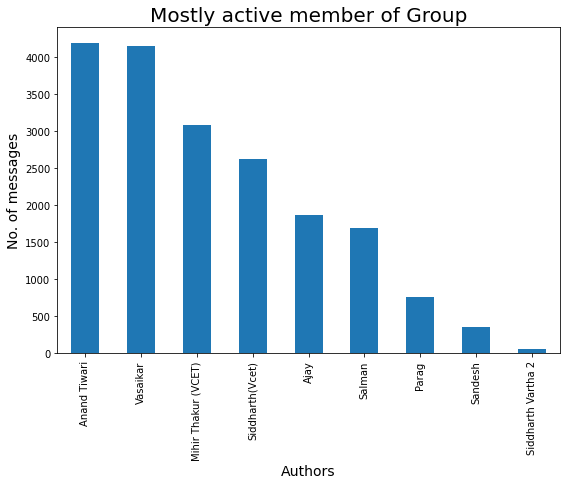

In [13]:
### Mostly Active Author in the Group
plt.figure(figsize=(9,6))
mostly_active = df['Author'].value_counts()
### Top 10 peoples that are mostly active in our Group is : 
m_a = mostly_active.head(10)
bars = df.Author.unique()
x_pos = np.arange(len(bars))
m_a.plot.bar()
plt.xlabel('Authors',fontdict={'fontsize': 14,'fontweight': 10})
plt.ylabel('No. of messages',fontdict={'fontsize': 14,'fontweight': 10})
plt.title('Mostly active member of Group',fontdict={'fontsize': 20,'fontweight': 8})
plt.xticks(x_pos, bars)
plt.show()

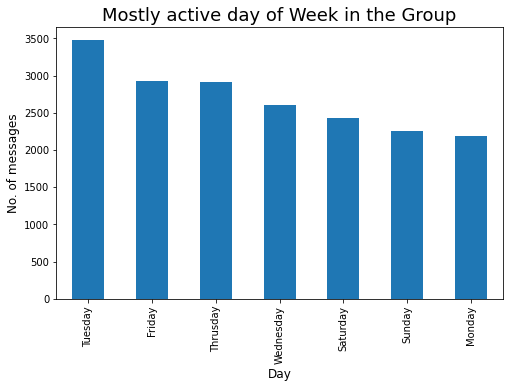

In [14]:
### Mostly Active day in the Group
plt.figure(figsize=(8,5))
active_day = df['Day'].value_counts()
### Top 10 peoples that are mostly active in our Group is : 
a_d = active_day.head(10)
a_d.plot.bar()
plt.xlabel('Day',fontdict={'fontsize': 12,'fontweight': 10})
plt.ylabel('No. of messages',fontdict={'fontsize': 12,'fontweight': 10})
plt.title('Mostly active day of Week in the Group',fontdict={'fontsize': 18,'fontweight': 8})
plt.show()

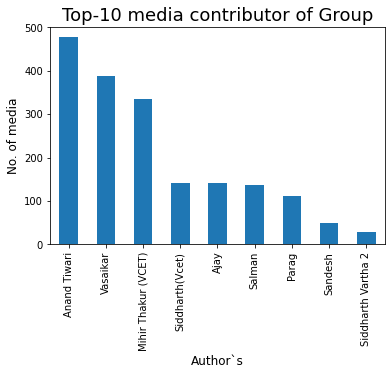

In [15]:
### Top-10 Media Contributor of Group
mm = df[df['Message'] == '<Media omitted>']
mm1 = mm['Author'].value_counts()
bars = df.Author.unique()
x_pos = np.arange(len(bars))
top10 = mm1.head(10)
top10.plot.bar()
plt.xlabel('Author`s',fontdict={'fontsize': 12,'fontweight': 10})
plt.ylabel('No. of media',fontdict={'fontsize': 12,'fontweight': 10})
plt.title('Top-10 media contributor of Group',fontdict={'fontsize': 18,'fontweight': 8})
plt.xticks(x_pos, bars)
plt.show()

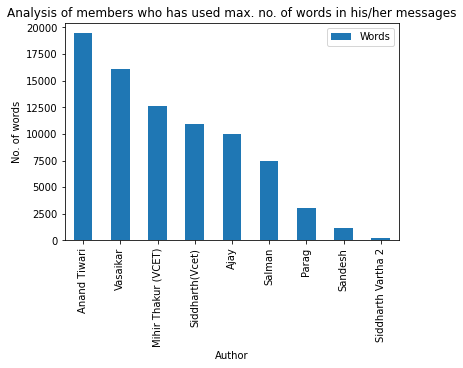

In [16]:
max_words = df[['Author','Words']].groupby('Author').sum()
m_w = max_words.sort_values("Words",ascending=False).head(10)
bars = df.Author.unique()
x_pos = np.arange(len(bars))
m_w.plot.bar(rot=90)
plt.xlabel('Author')
plt.ylabel('No. of words')
plt.title('Analysis of members who has used max. no. of words in his/her messages')
plt.xticks(x_pos, bars)
plt.show()

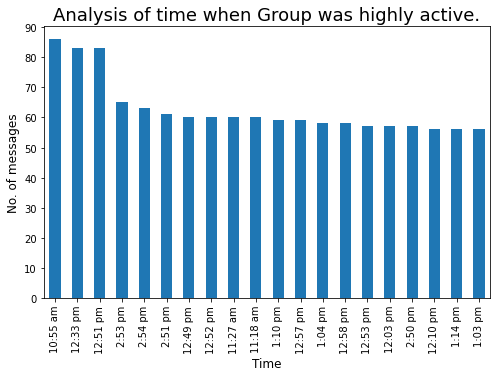

In [17]:
### Time whenever our group is highly active
plt.figure(figsize=(8,5))
t = df['Time'].value_counts().head(20)
tx = t.plot.bar()
tx.yaxis.set_major_locator(MaxNLocator(integer=True))  #Converting y axis data to integer
plt.xlabel('Time',fontdict={'fontsize': 12,'fontweight': 10})
plt.ylabel('No. of messages',fontdict={'fontsize': 12,'fontweight': 10})
plt.title('Analysis of time when Group was highly active.',fontdict={'fontsize': 18,'fontweight': 8})
plt.show()